# Preliminary Exploration of MIMIC-IV and MIMIC-III Databases - WIP

In [1]:
from creds import creds
import psycopg2
import pandas as pd
import pandas.io.sql as sqlio
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
# grab database credentials
host = creds.host
port = creds.port
uname = creds.username
pwd = creds.password

## MIMIC-IV

In [3]:
# establish connection

dbname = 'mimiciv'

conn_iv = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}"
                           .format(host, port, dbname, uname, pwd))

Total number of patients in the MIMIC-IV dataset

In [4]:
sql = 'select count (distinct subject_id) from mimic_core.patients;'
pd.read_sql_query(sql, conn_iv)

,count
0,382278


Tables in mimic_core module:

In [5]:
pd.read_sql_query("select column_name, data_type from information_schema.columns where table_schema = 'mimic_core' and table_name = 'patients'",conn_iv)

,column_name,data_type
0,subject_id,integer
1,gender,character
2,anchor_age,smallint
3,anchor_year,smallint
4,anchor_year_group,character varying
5,dod,date


In [6]:
pd.read_sql_query("select column_name, data_type from information_schema.columns where table_schema = 'mimic_core' and table_name = 'admissions'",conn_iv)

,column_name,data_type
0,subject_id,integer
1,hadm_id,integer
2,admittime,timestamp without time zone
3,dischtime,timestamp without time zone
4,deathtime,timestamp without time zone
5,admission_type,character varying
6,admission_location,character varying
7,discharge_location,character varying
8,insurance,character varying
9,language,character varying


In [7]:
pd.read_sql_query("select column_name, data_type from information_schema.columns where table_schema = 'mimic_core' and table_name = 'transfers'",conn_iv)

,column_name,data_type
0,subject_id,integer
1,hadm_id,integer
2,transfer_id,integer
3,eventtype,character varying
4,careunit,character varying
5,intime,timestamp without time zone
6,outtime,timestamp without time zone


#### MIMIC-IV Demographics

In [8]:
sql = 'select gender, count(distinct subject_id) from mimic_core.patients group by gender;'
gender_distribution = pd.read_sql_query(sql, conn_iv)
gender_distribution

,gender,count
0,F,199707
1,M,182571


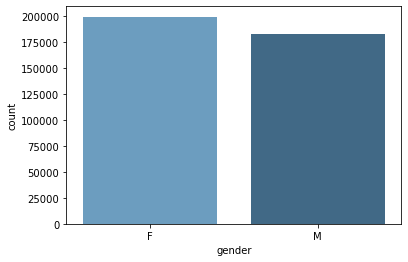

In [9]:
sns.barplot(y='count', x='gender', data=gender_distribution, palette="Blues_d", order=gender_distribution.sort_values('count', ascending=False).gender)
#plt.xticks(rotation=90)
plt.show()

In [10]:
sql = 'select ethnicity, count(distinct subject_id) from mimic_core.admissions group by ethnicity;'
ethnicity_distribution = pd.read_sql_query(sql, conn_iv)
ethnicity_distribution


,ethnicity,count
0,AMERICAN INDIAN/ALASKA NATIVE,992
1,ASIAN,16643
2,BLACK/AFRICAN AMERICAN,31666
3,HISPANIC/LATINO,13758
4,OTHER,18112
5,UNABLE TO OBTAIN,3377
6,UNKNOWN,17370
7,WHITE,161450


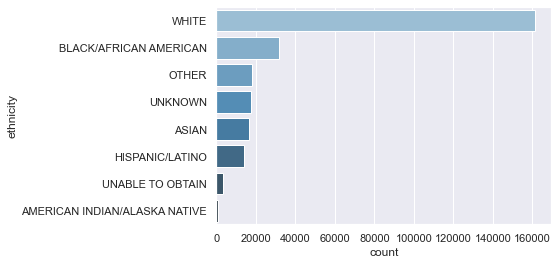

In [11]:
sns.set(style="darkgrid")

sns.barplot(y='ethnicity', x='count', data=ethnicity_distribution, palette="Blues_d", order=ethnicity_distribution.sort_values('count', ascending=False).ethnicity)
#plt.xticks(rotation=90)
plt.show()


Both ethnicity and race are combined under the ethnicity variable. See [https://github.com/MIT-LCP/mimic-code/issues/1236](https://github.com/MIT-LCP/mimic-code/issues/1236) for ongoing discussion on this.

In [12]:
all_patients = pd.read_sql_query('select * from mimic_core.patients', conn_iv)


In [13]:
all_patients.describe()['anchor_age']

count    382278.000000
mean         40.931804
std          26.114457
min           0.000000
25%          22.000000
50%          41.000000
75%          62.000000
max          91.000000
Name: anchor_age, dtype: float64

In [14]:
# anchor age distribution in 10yr bins:
sql = """
select '< 18' as Age_Category,count(anchor_age) as Count from mimic_core.patients
        where anchor_age >=0 and anchor_age < 18
     union (
     select '18-30' as Age_Category,count(anchor_age) as Count from mimic_core.patients
        where anchor_age between 18 and 30)
     union (
     select '31-40' as Age_Category,count(anchor_age) as Count from mimic_core.patients
        where anchor_age between 31 and 40)
     union (
     select '41-50' as Age_Category,count(anchor_age) as Count from mimic_core.patients
        where anchor_age between 41 and 50)
     union (
     select '51-60' as Age_Category,count(anchor_age) as Count from mimic_core.patients
        where anchor_age between 51 and 60)
     union (
     select '61-70' as Age_Category,count(anchor_age) as Count from mimic_core.patients
        where anchor_age between 61 and 70)
     union(
     select '71-80' as Age_Category,count(anchor_age) as Count from mimic_core.patients
        where anchor_age between 71 and 80)
     union(
     select '>= 81' as Age_Category,count(anchor_age) as Count from mimic_core.patients
        where anchor_age >= 81);      

"""
age_distribution = pd.read_sql_query(sql,conn_iv)
age_distribution

,age_category,count
0,>= 81,26805
1,61-70,43118
2,41-50,41892
3,31-40,43336
4,51-60,48838
5,18-30,86534
6,71-80,30883
7,< 18,60872


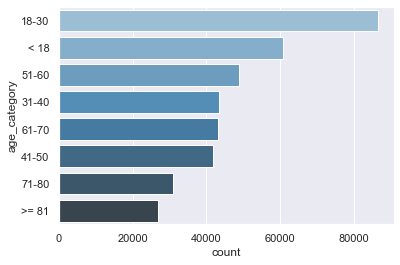

In [15]:

sns.barplot(y='age_category', x='count', data=age_distribution, palette="Blues_d", order=age_distribution.sort_values('count', ascending=False).age_category)
plt.show()

In [16]:
sql = 'select anchor_age, count(*) from mimic_core.patients group by anchor_age'
age_dist = pd.read_sql_query(sql, conn_iv)
[x for x in range(0, max(age_dist['anchor_age']), 10)] + [91]


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 91]

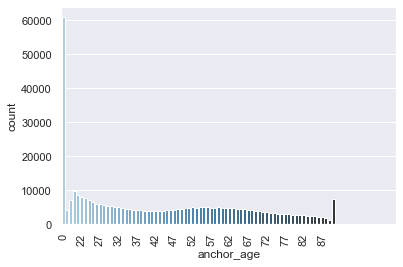

In [17]:
sns.barplot(x='anchor_age', y='count', data=age_dist, palette="Blues_d")
plt.xticks([x for x in range(0, max(age_dist['anchor_age']), 5)])
plt.xticks(rotation=90)

plt.show()

*For deidentification purposes all ages over 89 have been set  to the value of 91 which is pretty close to the median age for that group. 
"If you see a patient with an anchor_age of 91, then the only thing you know is that they were over 89 in the anchor_year."
(see note in mimic-iv tutorial by Alistair at https://colab.research.google.com/drive/1REu-ofzNzqsTT1cxLHIegPB0nGmwKaM0?usp=sharing#scrollTo=wlxWRhG_iLPB)

In [18]:
sql = 'select count(distinct subject_id) from mimic_core.admissions;'
pd.read_sql_query(sql, conn_iv)


,count
0,256878


In [19]:
sql = 'select count(*) from mimic_core.admissions;'
pd.read_sql_query(sql, conn_iv)

,count
0,523740


In [ ]:
pd.read_sql_query('select distinct language from mimic_core.admissions', conn_iv)


In [ ]:
sql = 'select language, count(distinct subject_id) from mimic_core.admissions group by language;'
pd.read_sql_query(sql, conn_iv)

In [ ]:
pd.read_sql_query('select distinct insurance from mimic_core.admissions', conn_iv)


In [ ]:
insurance_distribution = pd.read_sql_query('select insurance, count(distinct subject_id) from mimic_core.admissions group by insurance', conn_iv)
insurance_distribution

In [ ]:
sns.barplot(y='insurance', x='count', data=insurance_distribution, palette="Blues_d", order=insurance_distribution.sort_values('count', ascending=False).insurance)
#plt.xticks(rotation=90)
plt.show()

In [ ]:
marital_status_dist = pd.read_sql_query('select marital_status, count(distinct subject_id) from mimic_core.admissions group by marital_status', conn_iv)
marital_status_dist

In [ ]:
# close connection
conn_iv.close()

## MIMIC-III

In [ ]:
# grab database credentials
host = creds.host
port = creds.port
uname = creds.username3
pwd = creds.password3

# establish connection

dbname = 'mimiciii'

conn_iii = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}"
                            .format(host, port, dbname, uname, pwd))

Total number of patients in the MIMIC-III dataset

In [ ]:
sql = "SELECT count(*) from mimiciii.patients"
pd.read_sql_query(sql, conn_iii)

In [ ]:
# admissions table
pd.read_sql_query("select table_name from information_schema.tables where table_schema = 'mimiciii'", conn_iii)



The actual number of tables is 26 but this query has the chartevents table in 208 parts: chartevents, chartevents_1, ..., chartevents_207. Unsure why.

In [ ]:
sql = "select column_name, data_type from information_schema.columns where table_schema = 'mimiciii' and table_name = 'patients'"
pd.read_sql_query(sql, conn_iii)

In [ ]:
sql = "select column_name, data_type from information_schema.columns where table_schema = 'mimiciii' and table_name = 'admissions'"
pd.read_sql_query(sql, conn_iii)


#### MIMIC-III Demographics

In [ ]:
pd.read_sql_query('select min(dob), max(dob) from mimiciii.patients', conn_iii)

In [ ]:
sql = 'select gender, count(distinct subject_id) from mimiciii.patients group by gender'
gender_distribution = pd.read_sql_query(sql, conn_iii)
gender_distribution

In [ ]:
sql = 'select ethnicity, count(distinct subject_id) from mimiciii.admissions group by ethnicity'
ethnicity_distribution = pd.read_sql_query(sql, conn_iii)
ethnicity_distribution

In [ ]:
sql = 'select insurance, count(distinct subject_id) from mimiciii.admissions group by insurance'
insurance_distribution = pd.read_sql_query(sql, conn_iii)
insurance_distribution

In [ ]:
sql = 'select language, count(distinct subject_id) from mimiciii.admissions group by language'
language_distribution = pd.read_sql_query(sql, conn_iii)
language_distribution

In [ ]:
sql = 'select marital_status, count(distinct subject_id) from mimiciii.admissions group by marital_status'
marital_status_distribution = pd.read_sql_query(sql, conn_iii)
marital_status_distribution

In [ ]:
sql = 'select religion, count(distinct subject_id) from mimiciii.admissions group by religion'
religion_distribution = pd.read_sql_query(sql, conn_iii)
religion_distribution

In [ ]:
# close connection
conn_iii.close()